# Реализация алгоритма дифференциальных коррекций (пристрелки)

In [1]:
import numpy as np
from scipy import optimize, interpolate
import scipy
import os
import math

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from crtbp_ode import crtbp

from crtbp_prop import prop2Limits
from find_vel import findVLimits

from lagrange_pts import lagrange1, lagrange2

from stop_funcs import  iVarX, iVarY,iVarVY, iVarAlpha,\
iVarLyapunov, iVarLyapunovLeft, iVarLyapunovRight, stopNull

%matplotlib inline
plt.rcParams.update({'font.size': 14})

# Некоторые из следующих функций были изменены по сравнению с версией на 12.11.2018 [github.com/bobersa/crtbp](github.com/bobersa/crtbp)

# stopFunCombined

In [2]:
def stopFunCombined(t, s, lst, events, out=[], **kwargs):
    ''' Universal event detection function that handles multiple events. 
        Intended for scipy.integrate.ode solout application. Provides \
        termination of integration process when first terminate event occur. \
        This happens when independent variable associated with this event \
        goes through defined stopval value in specified direction.
        Uses almost the same ideas as in matlab event functions.
        Can be used for gathering all intergation steps.
        Shoudn't be called directly but through scipy.integrate.ode.
    
    Parameters
    ----------

    t : scalar
        Dimensionless time (same as angle of system rotation)
        
    s : array_like with 6 components
        State vector of massless spacecraft (x,y,z,vx,vy,vz)

    lst : list
        Every call of this function put [*s,t,*cur_ivs] into lst, where 
        t - time (at current integration step),
        s - spacecraft state vector at time t,
        cur_ivs - list of independent variable values at time t.
        
    events : list of dicts
        Each dict consists of necessary information for event:
        {
        
        ivar : function(t, s, **kwargs)
            Should return independent variable from spacecraft state vector.
        
        stopval : double
            stopFun return -1 if independent variable crosses stopval value in
            right direction
        
        direction : integer
            1 : stops integration when independent variable crosses stopval value
                 from NEGATIVE to POSITIVE values
            -1 : stops integration when independent variable crosses stopval value
                 from POSITIVE to NEGATIVE values
            0 : in both cases
                 (like 'direction' argument in matlab's event functions)
                 
        isterminal : integer, bool         
            Terminal event terminates integration process when event occurs.
            
        corr : bool
            Determines whether it is necessary to adjust last state vector or not
        
        count : int
            Number of event occasions.
            If count == 0
            Then event doesnt occur (turned off event).
            
            If count == -1
            Then (possibly) unlimited number of events can occur.
            
            If isterminal == True
                If count == 1
                Then only one terminal event (possibly) occur.
                If count > 1
                Then non-terminal event (possibly) triggers count-1
                times and one terminal event (possibly) occur.
            If isterminal == False
                Event (possibly) occurs count times.

        kwargs : dict
            Other parameters for ivar function
        }
        
    out : list
        If non-terminal event(s) occur in [ti-1, ti] interval, 'out' will
        be filled with [ei, ci, np.array([*s,te,*cur_ivs])], where:
        ei - event index in events list,
        ci - event triggered ci times,
        te - time of event,
        s - state vector at te,
        cur_ivs - values of independent variables at te.
              
    Returns
    -------
    
    -1 : scalar
        When there are terminal event in event list and independent variable \
        associated with this event goes through defined stopval value in \
        specified direction. Will be treated by scipy.integrate.ode as it \
        should stop integration process.
        
    0 : scalar
        Otherwise. Will be treated by scipy.integrate.ode as it\
        should continue integration process.
        
          
    '''
    if not events:
        return 0
    
    terminal = False
    cur_ivs = []
    sn = s.shape[0] + 1
        
    for event in events:
        ivar = event['ivar']
        evkwargs = event.get('kwargs', {})        
        cur_iv = ivar(t, s, **evkwargs)
        cur_ivs.append(cur_iv)

    if not lst: # fast way to check if lst is empty
        cur_cnt = []
        for event in events:
            cur_cnt.append(event.get('count', -1))
        if not out:
            out.append(cur_cnt)
        else:
            out[0] = cur_cnt
#        lst.append(np.asarray([*s,t,*cur_ivs]))
        lst.append([*s,t,*cur_ivs])
        return 0
        
#    lst.append(np.asarray([*s,t,*cur_ivs]))
    lst.append([*s,t,*cur_ivs])

    cur_cnt = out[0]
    for i, event in enumerate(events):
        stopval = event.get('stopval', 0)
        direction = event.get('direction', 0)
        corr = event.get('corr', True)
        isterminal = event.get('isterminal', True)
        init_cnt = event.get('count', -1)
        
        cur_iv = cur_ivs[i]
        prev_iv = lst[-2][sn+i]

        f1 = (prev_iv < stopval) and (cur_iv > stopval) and ((direction == 1) or (direction == 0))
        f2 = (prev_iv > stopval) and (cur_iv < stopval) and ((direction == -1) or (direction == 0))
        if (f1 or f2) and ((cur_cnt[i] == -1) or (cur_cnt[i] > 0)):
            if cur_cnt[i] > 0:
                cur_cnt[i] -= 1
           
            out.append([i, # event index
                        (-1 if cur_cnt[i]==-1 else init_cnt-cur_cnt[i]), # event trigger counter
                        lst[-2].copy(), # state before event
                        lst[-1].copy(), # state after event
                        corr, # if correction is needed
                        isterminal]) # if event is terminal
            if isterminal and ((cur_cnt[i] == -1) or (cur_cnt[i] == 0)):
                terminal = True
            
    if terminal:
        return -1
    
    return 0

# propCrtbp

In [3]:
def propCrtbp(mu, s0, tspan, retarr=True, **kwargs):
    ''' Propagate spacecraft in CRTBP.
        Uses scipy.integrate.ode with 'dopri5' integrator.
    
    Parameters
    ----------
    mu : scalar
        CRTBP mu1 coefficient.

    s0 : array_like with 6 components
        Initial spacecraft state vector (x0,y0,z0,vx0,vy0,vz0).
        
    tspan : array_like with 2 components
        Initial and end time.
        
    Optional
    --------
    
    stopf : function
        Solout function for integrator.
        
    int_param : dict
        Parameters for 'dopri5' integrator.
        
    Returns
    -------
    
    Yt : np.array
      Array of (n,6) shape of state vectors and times
      for each integrator step (xi,yi,zi,vxi,vyi,vzi,ti)
    
    See Also
    --------
    
    scipy.integrate.ode, crtbp_ode.crtbp
       
    '''
    prop = scipy.integrate.ode(crtbp)

    if 'int_param' in kwargs:
        method = kwargs['int_param'].get('method', 'dopri5')
        prop.set_integrator(method, **kwargs['int_param'])
    else:
        prop.set_integrator('dopri5')

    prop.set_initial_value(s0, tspan[0])
    prop.set_f_params(*[mu])

    lst = []
    kwargs['mu'] = mu
    #print(kwargs)
    if 'stopf' in kwargs:
        prop.set_solout(lambda t, s: kwargs['stopf'](t, s, lst, **kwargs))
    else:
        prop.set_solout(lambda t, s: stopNull(t, s, lst))
    prop.integrate(tspan[1])

    del prop
    
    evout = kwargs.get('out', [])
    if len(evout) > 1:
        events = kwargs.get('events', [])
#        cor_out = correctEvents(events, evout, prop, sn=len(s0),
#                            tol=kwargs['int_param']['atol'])
        cor_out = correctEvents(events, evout, None, sn=len(s0),
                            tol=kwargs['int_param']['atol'], 
                            int_param=kwargs['int_param'],
                            mu1=kwargs['mu'])
        evout.clear()
        evout.extend(cor_out)
    
    if retarr:
        return np.asarray(lst)

# correctEvents

In [4]:
def correctEvents(events, evout, prop, tol=1e-12, sn=6, maxiter=50, **kwargs):
    '''
        Calculate corrected event states using newton method with
        same tolerance as integrator used.
        
    Parameters
    ----------
    
    events : list of events
        See stopFunCombined for description
        
    evout : list (generated by stopFunCombined)
        evout elements are lists where (by index):
            0 - event index
            1 - event trigger count
            2 - state before event
            3 - state after event
            4 - correction flag
            5 - terminal flag
            
    sn : integer
        State vector length
        
    maxiter : integer
        Number of iterations for newton to converge.
        
    mu : scalar
        Crtbp mass parameter.
        
    int_params : dict
        Integration parameters, see propCrtbp for description.
            
    Returns
    -------

    out : list
        out elements are lists where (by index):
            0 - event index
            1 - event trigger count
            2 - corrected state or state after event (depends on evout[i][4])
            3 - terminal flag
    '''
    out = []

#    prop = ode(crtbp)
#    prop.set_f_params(kwargs['mu'])
#    method = kwargs['int_param'].get('method', 'dopri5')
#    prop.set_integrator(method, **kwargs['int_param'])
#    atol = kwargs['int_param']['atol']

    for ev in evout[1:]:
        if ev[4] == False:
            out.append([ev[0], ev[1], ev[3][:sn+1], ev[5]])
            continue

        ret = newton_int(events[ev[0]], 
                         ev[2][sn], 
                         ev[2][:sn], 
                         tol=tol,
                         maxiter=maxiter,
                         **kwargs)
        if ret is None:
            print('Newton failed -> Calling Brent :)')
            t, s = brent(events[ev[0]], 
                         ev[2][sn], 
                         ev[3][sn], 
                         ev[2][:sn], 
                         tol=tol,
                         maxiter=maxiter,
                         **kwargs)
        else:
            t, s = ret

        out.append([ev[0], ev[1], list(s)+[t], ev[5]])
        
    return out

# newton_int

In [5]:
def newton_int(event, t0, s0, mu1, int_param, tol=1e-12, maxiter=50, debug=False):
    from crtbp_prop import propCrtbp
    """
    Special edition of Newton method for event-finding process.
    Slower but bug-free version.
    
    Parameters
    ----------
    
        event : dict
            See event description in stopFunCombined.
            
        t0 : scalar
            Epoch to start converge from.
            
        s0 : array-like
            State vector to start converge from.
            
        mu1 : scalar
            Gravitational constant of crtbp.
            
        int_param : dict
            Integrator parameters.
            
        tol : scalar
            Tolerance. 
            |event_fun(t, s) - stopval| < tol
            
    Returns
    -------
        (t, s): tuple
            t - epoch when event occur
            s - state vector when event occur
            
        None
            If method wasn't converged within maxiter iterations.
            
    """
    
    ivar = event['ivar']
    dvar = event['dvar']
    stopval = event['stopval']
    evkwargs = event.get('kwargs', {})
    
    t = t0
    s = s0.copy()

    if debug:
        lst = []
    
    for _ in range(maxiter):
        fder = dvar(t, s, **evkwargs)
        if fder == 0:
            msg = "derivative was zero."
            warnings.warn(msg, RuntimeWarning)
            return t, s
        fval = ivar(t, s, **evkwargs) - stopval
        if debug:
            lst.append((t, fval, fder))

        if math.fabs(fval) < tol:
            return t, s

        newton_step = fval / fder
        t1 = t - newton_step
        if len(s0) > 40:
            s1 = propCrtbpSTM(mu1, s0, [t0, t1], int_param=int_param)[-1, :42]
        else:
            s1 = propCrtbp(mu1, s0, [t0, t1], int_param=int_param)[-1, :6]
#        prop.set_initial_value(s0, t0)
#        s1 = prop.integrate(t1)

        t = t1
        s = s1.copy()

    if debug:
        lst = np.array(lst)
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        ax[0].plot(range(len(lst)), lst[:,0])
        ax[0].set_title('steps')
        ax[1].plot(lst[:,0], lst[:,1], 'r')
        ax[1].set_title('fval')
        ax[2].plot(lst[:,0], lst[:,2], 'g')
        ax[2].set_title('fder')
        fig.tight_layout()

#    print('\nt0:', t0, '\ns0:', s0)
#    msg = "Failed to converge after %d iterations, value is %s" % (maxiter, t)
#    raise RuntimeError(msg) 
    return None

# brent

In [6]:
def brent(event, t0, t1, s0, mu1, int_param, tol=1e-12, maxiter=50, debug=False):
    from crtbp_prop import propCrtbp
    import scipy.optimize
    """
    Special edition of Brent method for event-finding process.
    Slower than Newton method but converges better. This method 
    used when Newton's method can't converge.
    """
    
    ivar = event['ivar']
#    dvar = event['dvar']
    stopval = event['stopval']
    evkwargs = event.get('kwargs', {})
    
    s_opt = [0]
    
    def fopt(t, s0, t0):
        if t == t0:
            s = s0.copy()
        else:
            if len(s0) > 40:
                s = propCrtbpSTM(mu1, s0, [t0, t], int_param=int_param)[-1, :42]
            else:
                s = propCrtbp(mu1, s0, [t0, t], int_param=int_param)[-1, :6]
        s_opt[0] = s
        fval = ivar(t, s, **evkwargs) - stopval
        return math.fabs(fval)
        
    t_opt = scipy.optimize.brent(fopt, args=(s0, t0), brack=(t0, t1), tol=tol)

    return t_opt, s_opt[0]
    

# crtbp_plot.py

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def omega(y, mu2):
    if len(y.shape) == 1:
        r1 = np.sqrt((y[0] + mu2)**2 + y[1]**2 + y[2]**2)
        r2 = np.sqrt((y[0] - 1 + mu2)**2 + y[1]**2 + y[2]**2)
        return 0.5*(y[0]**2 + y[1]**2) + (1 - mu2) / r1 + mu2 / r2        
    else:
        r1 = np.sqrt((y[:,0] + mu2)**2 + y[:,1]**2 + y[:,2]**2)
        r2 = np.sqrt((y[:,0] - 1 + mu2)**2 + y[:,1]**2 + y[:,2]**2)
        return 0.5*(y[:,0]**2 + y[:,1]**2) + (1 - mu2) / r1 + mu2 / r2
    
def jacobi_const(y, mu2=0.0121505856):
    if len(y.shape) == 1:
        return 2*omega(y, mu2) - y[3]**2 - y[4]**2 - y[5]**2
    else:
        return 2*omega(y, mu2) - y[:,3]**2 - y[:,4]**2 - y[:,5]**2

# omega and jacobi for planar problem
def omega_planar(y, mu2):
    r1 = np.sqrt((y[:,0] + mu2)**2 + y[:,1]**2 )
    r2 = np.sqrt((y[:,0] - 1 + mu2)**2 + y[:,1]**2 )
    return 0.5*(y[:,0]**2 + y[:,1]**2) + (1 - mu2) / r1 + mu2 / r2
    
def jacobi_const_planar(y, mu2=0.0121505856):
    return 2*omega_planar(y, mu2) - y[:,2]**2 - y[:,3]**2 
    
def dimless2km(y, L, ME):
    ykm = y.copy()
    if len(ykm.shape) == 1:
        ykm[0] = (ykm[0] - L[1])*ME
        ykm[1] *= ME
        ykm[2] *= ME
    else:
        ykm[:,0] = (ykm[:,0] - L[1])*ME
        ykm[:,1] *= ME
        ykm[:,2] *= ME
    return ykm

def plot_3projections(arr_l, save=False, scatter=False, NAME='EML2 '):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches((15,5))
    
    if type(arr_l) is list:
        pass
    else:
        arr_l = [arr_l]
        
    for arr in arr_l:
        if scatter:
            ax[0].scatter(arr[:,0],arr[:,1], s=3)
            ax[1].scatter(arr[:,0],arr[:,2], s=3)
            ax[2].scatter(arr[:,1],arr[:,2], s=3)
        else:
            ax[0].plot(arr[:,0],arr[:,1])
            ax[1].plot(arr[:,0],arr[:,2])
            ax[2].plot(arr[:,1],arr[:,2])

        ax[0].set(xlabel='X', ylabel='Y')
        ax[1].set(xlabel='X', ylabel='Z')
        ax[2].set(xlabel='Y', ylabel='Z')
    
    #ykm = dimless2km(arr[0,:])
    
    #plt.title(str([int(ykm[0]), int(ykm[1]), int(ykm[2])]))
    
    if save:
        plt.savefig('pics/debug ' + NAME + str([int(ykm[0]), int(ykm[1]), int(ykm[2])])+'.png')
    return fig, ax

# Основная часть

In [8]:
Sm =  1.9891e30 # mass of the Sun
Em =  5.97e24 # mass of the Earth
Mm =  7.34767e22 # mass of the Moon
ER =  1.496e8 # Sun-Earth distance
ME =  384400
#mu2 = Em / (Sm + Em) # CRTBP main coefficient

#mu2 = 0.01217414317#   # Mm/(Em+Mm)
mu2 = 0.0121505856

mu1 = 1-mu2

L = [lagrange1(mu1), lagrange2(mu1)] # L1, L2 positions


rtol = 1e-12 # integration relative tolerance
nmax = 1e6 # max number of integration steps
int_param = {'atol':rtol, 'rtol':rtol, 'nsteps':nmax}

In [9]:
# события для EML2

eventA = {'ivar':iVarAlpha, 'stopval': np.deg2rad(170), 'direction':0, 'isterminal':True, 'corr':False, 'kwargs':{'center':mu1+1/ME}}
eventB = {'ivar':iVarAlpha, 'stopval': np.deg2rad(-170), 'direction':0, 'isterminal':True, 'corr':False, 'kwargs':{'center':mu1+1/ME}}
eventR = {'ivar':iVarX, 'stopval':   L[1]+60000/ME, 'direction':0, 'isterminal':True,  'corr':False}
eventL = {'ivar':iVarX, 'stopval':   mu1 + 1/ME, 'direction':0, 'isterminal':True,  'corr':False}
eventY = {'ivar':iVarY, 'stopval':   -0.8, 'direction':0, 'isterminal':True,  'corr':False}


eventRevHalf = {'ivar':iVarY,'dvar':iVarVY, 'stopval':   0, 'direction': 0,'count':1, 'isterminal':True,  'corr':True}

eventRev = {'ivar':iVarY,'dvar':iVarVY, 'stopval':   0, 'direction': 0,'count':2, 'isterminal':True,  'corr':True}

lims = {'left':[eventA, eventB], 'right':[eventR, eventY]}
#lims = {'left' : [eventL], 'right' : [eventR]}

In [10]:
x0 = np.array([1.1203763479732245, 0,  0.00117062167552358, 0,  0.1760691838348937, 0])


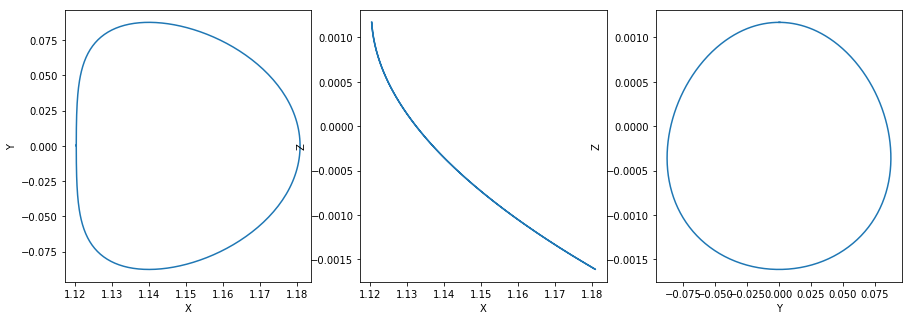

In [11]:
evout = []
halo_x0 = propCrtbp(mu1, x0, [0, 5*np.pi], stopf=stopFunCombined,\
              events = [eventRev], out=evout, int_param=int_param)
halo_x_end = np.array(evout[-1][2][:6]).reshape(-1,1)
period = evout[-1][2][6]
plot_3projections(halo_x0[:,:6]);

Точное состояние КА в момент свершения события хранится в списке evout

Обратите внимание, как различаются последнее состояние в массиве halo_x0 и в списке evout

(y в первом случае порядка e-4, во втором e-17)

In [12]:
halo_x0[-1,:7], np.array(evout[-1][2][:7])

(array([ 1.12037643e+00,  6.80977126e-04,  1.17057002e-03,  4.10220142e-05,
         1.76062573e-01, -2.67105741e-05,  3.41937731e+00]),
 array([1.12037635e+00, 3.19839641e-17, 1.17062168e-03, 3.87748190e-13,
        1.76069184e-01, 1.93825804e-14, 3.41550959e+00]))

In [13]:
def get_A(y, mu2):
    mu1 = 1-mu2
    r1 = np.sqrt((y[0] + mu2)**2 + y[1]**2 +y[2]**2)
    r13, r15 = r1**3, r1**5
    r2 = np.sqrt((y[0] - 1 + mu2)**2 + y[1]**2 +y[2]**2)
    r23, r25 = r2**3, r2**5
    
    Uxx = 1-mu1/r13 -mu2/r23 + 3*mu1*(y[0]+mu2)**2/r15 + 3*mu2*(y[0]-mu1)**2/r25
    Uxy = 3*mu1*(y[0]+mu2)*y[1]/r15 + 3*mu2*(y[0]-mu1)*y[1]/r25
    Uxz = 3*mu1*(y[0]+mu2)*y[2]/r15 + 3*mu2*(y[0]-mu1)*y[2]/r25
    

    Uyy = 1-mu1/r13 -mu2/r23 + 3*mu1*y[1]**2/r15 + 3*mu2*y[1]**2/r25
    Uyz = 3*mu1*y[1]*y[2]/r15 + 3*mu2*y[1]*y[2]/r25
    
    Uzz = -mu1/r13 -mu2/r23 + 3*mu1*y[2]**2/r15 + 3*mu2*y[2]**2/r25
    
    B = np.array([[Uxx, Uxy, Uxz], [Uxy, Uyy, Uyz], [Uxz, Uyz, Uzz]])
    I = np.identity(3)
    C = np.array([[0,2, 0], [-2,0,0], [0,0,0]])
    A = np.zeros((6,6))
    A[3:, 3:] += C
    A[:3, 3:] += I
    A[3:, :3] += B
    return A
    

In [14]:
def all_int(t, X, mu2):
    y = X[:6].reshape(6,)
    yn = crtbp(t, y, 1-mu2).reshape(1, -1)    
    A = get_A(y, mu2)
    Ph = X[6:].reshape(6, -1)
    Ph = A@Ph
    return np.ndarray.flatten(np.vstack((yn, Ph)))
    

In [15]:
def propCrtbpSTM(mu, s0, tspan,retarr=True, **kwargs):
    ''' Propagate spacecraft in CRTBP and calculates State Transition Matrix.
        Uses scipy.integrate.ode with 'dopri5' integrator.
    
    Parameters
    ----------
    mu : scalar
        CRTBP mu1 coefficient.

    s0 : array_like with 42 components
        Initial spacecraft state vector (x0,y0,z0,vx0,vy0,vz0) + Phi matrix (6x6)
        s0 id flatten array 7x6, where the first line is spacecraft state vector
        
    tspan : array_like with 2 components
        Initial and end time.
        
    Optional
    --------
    
    stopf : function
        Solout function for integrator.
        
    int_param : dict
        Parameters for 'dopri5' integrator.
        
    Returns
    -------
    
    Yt : np.array
      Array of (n,6) shape of state vectors and times
      for each integrator step (xi,yi,zi,vxi,vyi,vzi,ti)
    
    See Also
    --------
    
    scipy.integrate.ode, crtbp_ode.crtbp
       
    '''
    prop = scipy.integrate.ode(all_int)
    prop.set_initial_value(s0, tspan[0])
    prop.set_f_params(1-mu)# prop.set_f_params(1-mu)
    if 'int_param' in kwargs:
        prop.set_integrator('dopri5', **kwargs['int_param'])
    else:
        prop.set_integrator('dopri5')
    lst = []
    kwargs['mu'] = mu
    #print(kwargs)
    if 'stopf' in kwargs:
        prop.set_solout(lambda t, s: kwargs['stopf'](t, s, lst, **kwargs))
    else:
        prop.set_solout(lambda t, s: stopNull(t, s, lst))
    prop.integrate(tspan[1])
    del prop
    
    evout = kwargs.get('out', [])
    if len(evout) > 1:
        events = kwargs.get('events', [])
#        cor_out = correctEvents(events, evout, prop, sn=len(s0),
#                            tol=kwargs['int_param']['atol'])
        cor_out = correctEvents(events, evout, None, sn=len(s0),
                            tol=kwargs['int_param']['atol'], 
                            int_param=kwargs['int_param'],
                            mu1=kwargs['mu'])
        evout.clear()
        evout.extend(cor_out)
    
    if retarr:
        return np.asarray(lst)

# [Introduction to libration points](http://coweb.elec.canterbury.ac.nz/cda/uploads/mcinnes-intro_to_libration_point_orbits.pdf)

The general form of the solution to the system in equation (43) is
δx(t) = Φ(t, t0)δx(t0) , (44)
where Φ(t, t0) is the state transition matrix (STM). The STM is a linear map from the initial state
at the initial time t0 to a state at some later time t, and thus offers a tool to approximate the
impact of variations in the initial state on the evolution of the trajectory. 

In [16]:
int_param = {'atol': 1e-16, 'nsteps': 1000000.0, 'rtol': 1e-16}

In [17]:
# возмущаем начальную координату x 
halodq = x0.copy().reshape(6,1)
dq = np.array([1e-6, 0, 1e-6, 0, 0, 0], ndmin=2).reshape(-1,1)
halodq += dq


In [18]:
# интегрируем орбиту и считаем матрицу STM

s0 = np.ndarray.flatten(np.vstack(( x0.reshape(1,-1), np.identity(6))))

evout = []
#orb_stm = propCrtbpSTM(mu1, s0, [0, 7*np.pi], stopf=stopFunCombined,\
#                      events = [eventRev], out=evout, int_param=int_param)

orb_stm = propCrtbpSTM(mu1, s0, [0, period],int_param=int_param)


In [19]:
stm_t = orb_stm[-1][6:42].reshape(6,6)
#stm_t = np.array(evout[-1][2][6:42]).reshape(6,6)

In [20]:
# интегрируем возмущенный массив
evout = []
#halodqarr = propCrtbp(mu1, halodq, [0, 7*np.pi],stopf=stopFunCombined,\
#                      events = [eventRev], out=evout,  int_param=int_param)
halodqarr = propCrtbp(mu1, halodq, [0, period],  int_param=int_param)
halodq_x_end = halodqarr[-1,:6].reshape(-1,1)
#halodq_x_end = np.array(evout[-1][2][:6]).reshape(-1,1)

In [21]:
# сравниваем последнее состояние для возмущенной гало орбиты 
# и невозмущенной с поправкой STM

halodq_x_end - (halo_x_end + stm_t@dq)

array([[-6.74673712e-06],
       [ 1.27646689e-06],
       [-6.42893434e-08],
       [-3.45574298e-05],
       [-3.17730946e-06],
       [-3.66068757e-07]])

In [22]:
# сравниваем последнее состояние для возмущенной гало орбиты 
# и невозмущенной без поправки STM

halodq_x_end - halo_x_end

array([[ 1.02394528e-03],
       [-1.11233496e-03],
       [ 5.70354903e-06],
       [ 3.02429287e-03],
       [-2.00075097e-03],
       [ 3.42525623e-05]])

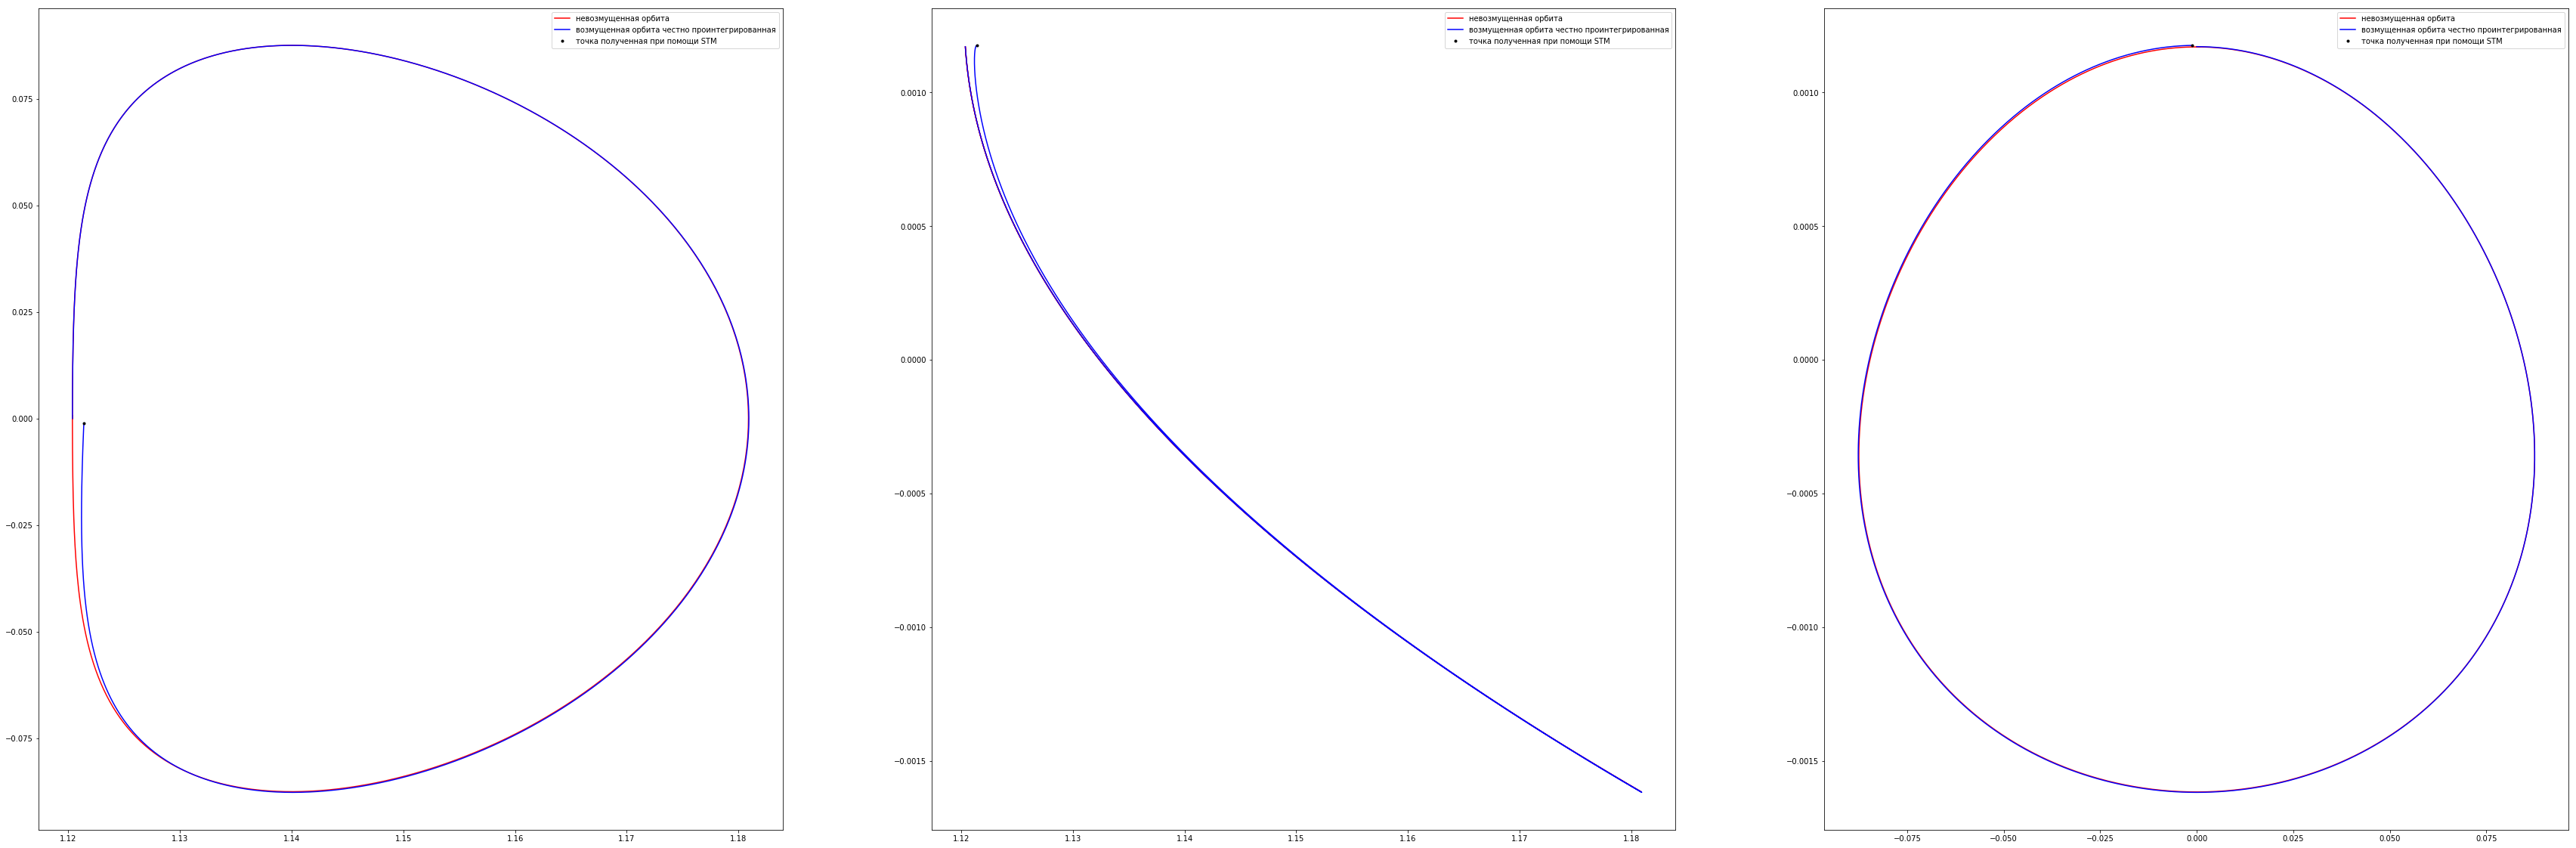

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(60,20))

# невозмущенная орбита
ax[0].plot(halo_x0[:,0], halo_x0[:,1], 'r', label='невозмущенная орбита')
ax[1].plot(halo_x0[:,0], halo_x0[:,2], 'r', label='невозмущенная орбита')
ax[2].plot(halo_x0[:,1], halo_x0[:,2], 'r', label='невозмущенная орбита')
# возмущенная орбита честно проинтегрированная
ax[0].plot(halodqarr[:,0], halodqarr[:,1], 'b',label='возмущенная орбита честно проинтегрированная')
ax[1].plot(halodqarr[:,0], halodqarr[:,2], 'b',label='возмущенная орбита честно проинтегрированная')
ax[2].plot(halodqarr[:,1], halodqarr[:,2], 'b',label='возмущенная орбита честно проинтегрированная')
# точка полученная при помощи STM
ax[0].plot((halo_x_end + stm_t@dq)[0], (halo_x_end + stm_t@dq)[1], '.k',label='точка полученная при помощи STM')
ax[1].plot((halo_x_end + stm_t@dq)[0], (halo_x_end + stm_t@dq)[2], '.k',label='точка полученная при помощи STM')
ax[2].plot((halo_x_end + stm_t@dq)[1], (halo_x_end + stm_t@dq)[2], '.k',label='точка полученная при помощи STM')

ax[0].legend()
ax[1].legend()
ax[2].legend()

# [Howell 3-dimensional, periodic, 'halo' orbits 1984](https://engineering.purdue.edu/people/kathleen.howell.1/Publications/Journals/1984_CM_How.pdf)



In [24]:
def find_halo(x, fixed, retIt=False, n=30):
    dt = 0
    i = 0
    while i < n:
        lst_xf = []
        evout = []
        s = np.ndarray.flatten(np.vstack(( x.reshape(1,-1), np.identity(6))))
        x_lst = propCrtbpSTM(mu1, s, [0, 7*np.pi], stopf=stopFunCombined,\
                      events = [eventRevHalf], out=evout, int_param=int_param)
        ev = np.array(evout[-1][2])
        xf = ev[:6]
        dxdt = crtbp(0, xf, mu2)
        Phi = ev[6:42].reshape(6, 6)

        if abs(xf[3]) < 1e-6 and abs(xf[5]) < 1e-6:
            break

        if fixed == 'x0':
            m = np.array([[Phi[3,2], Phi[3,4]], [Phi[5,2], Phi[5,4]]])\
            -1/dxdt[1]*np.array([[dxdt[3]],[dxdt[5]]])@np.array([Phi[1,2], Phi[1,4]], ndmin=2)
            dx = np.linalg.inv(m)@(-xf[[3,5]])
            x[[2,4]] += dx
            
        if fixed == 'z0':
            m = np.array([[Phi[3,0], Phi[3,4]], [Phi[5,0], Phi[5,4]]])\
            -1/dxdt[1]*np.array([[dxdt[3]],[dxdt[5]]])@np.array([Phi[1,0], Phi[1,4]], ndmin=2)
            dx = np.linalg.inv(m)@(-xf[[3,5]])
            x[[0,4]] += dx 


        i += 1
    if i < n:
        print("Converged i=", i, "halo", x)    
    else:
        print("Hasn't converged")
    if retIt:
        return x.copy(), i
    return x.copy()


## Пример работы дифференциальных коррекций при фиксированной координате Z0

Converged i= 4 halo [1.05119069 0.         0.0752     0.         0.36979622 0.        ]


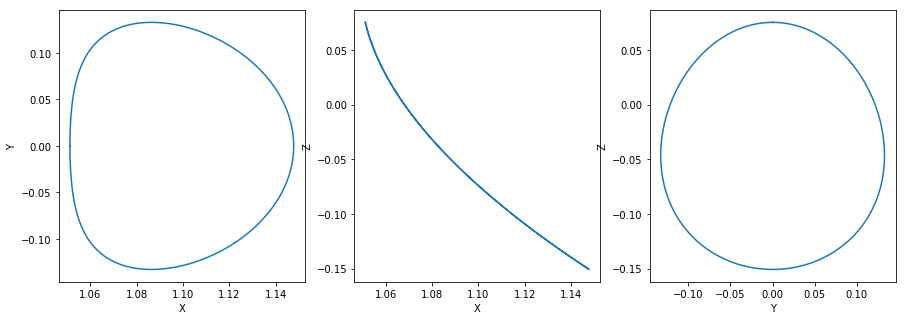

In [25]:
x = np.array([1.051, 0., 0.0752, 0., 0.37036254, 0.])

xh = find_halo(x, 'z0')

orb = propCrtbp(mu1, xh, [0, 7*np.pi], stopf=stopFunCombined,\
                  events = [eventRev], out=[], int_param=int_param)

plot_3projections(orb);


## Пример работы дифференциальных коррекций при фиксированной координате X0

Converged i= 5 halo [1.051      0.         0.07521997 0.         0.37036226 0.        ]


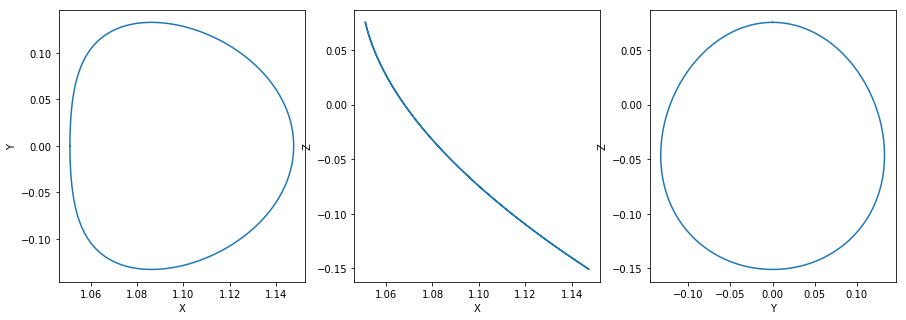

In [26]:
x = np.array([1.051, 0., 0.0752, 0., 0.37036254, 0.])

xh = find_halo(x, 'x0')

orb = propCrtbp(mu1, xh, [0, 7*np.pi], stopf=stopFunCombined,\
                  events = [eventRev], out=[], int_param=int_param)

plot_3projections(orb);
